In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
def metrics_calc(conf_mat):
        # Format of conf_mat should be: [TP, TN, FP, FN]
        TP = conf_mat[0]
        TN = conf_mat[1]
        FP = conf_mat[2]
        FN = conf_mat[3]
        accuracy = (TP+TN)/(TP+TN+FP+FN)
        sensitivity = TP/(TP+FN)
        specificity = TN/(TN+FP)
        precision = TP/(TP+FP)
        miss_rate = FN/(FN+TP)
        false_discovery_rate = FP/(FP+TP)
        false_omission_rate = FN/(FN+TN)

        return f""" 
        Accuracy is {accuracy:.2}
        Sensitivity is {sensitivity:.2}
        Specificity is {specificity:.2}
        Precision is {precision:.2}
        Miss Rate is {miss_rate:.2}
        False discovery rate is {false_discovery_rate:.2} 
        False omission rate is {false_omission_rate:.2} 
        """

In [3]:
df = pd.read_csv('new_mutations.csv')

In [4]:
df

,class,GOT1_GRCh37_10:101163586-101163586_Missense-Mutation_SNP_C-C-T,TEX36_GRCh37_10:127371546-127371546_Nonsense-Mutation_SNP_G-G-A,KIAA1217_GRCh37_10:24810824-24810824_Missense-Mutation_SNP_C-C-T,SIRT1_GRCh37_10:69676051-69676051_Missense-Mutation_SNP_C-C-T,MYPN_GRCh37_10:69881845-69881845_Missense-Mutation_SNP_C-C-T,LARP4B_GRCh37_10:890939-890939_Frame-Shift-Del_DEL_T-T--,NPAT_GRCh37_11:108032094-108032094_Missense-Mutation_SNP_G-G-T_G-G-A,ARNTL_GRCh37_11:13402723-13402723_Silent_SNP_G-G-A,COPB1_GRCh37_11:14480092-14480092_Missense-Mutation_SNP_G-G-A_G-G-T,...,FBXO21_GRCh37_12:117624320-117624320_Frame-Shift-Del_DEL_A-A--,CLRN1_GRCh37_3:150644691-150644691_3'UTR_DEL_A-A--,VPS37A_GRCh37_8:17153149-17153149_3'UTR_DEL_A-A--,VANGL2_GRCh37_1:160398257-160398258_3'UTR_INS_----G,SRGAP3_GRCh37_3:9023972-9023972_3'UTR_DEL_A-A--,PTENP1_GRCh37_9:33674774-33674774_RNA_DEL_T-T--,KMT2C_GRCh37_7:151836804-151836804_Nonsense-Mutation_SNP_G-G-A,CDKN1C_GRCh37_11:2904846-2904846_3'UTR_DEL_T-T--,PIK3R2_GRCh37_19:18278070-18278070_Missense-Mutation_SNP_A-A-G,LMO7_GRCh37_13:76432354-76432354_3'UTR_SNP_C-C-T
0,NC1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,C1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NC2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NC3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NC4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,NC140,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246,C107,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
247,NC141,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
248,C108,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X = df.drop("class", axis=1)
y = df["class"]

In [6]:
# convert cancer -> 1 and non-cancer -> 0
for i in range(len(y)):
    if y[i][0]=="C":
        y[i]=1
    else:
        y[i]=0

/var/folders/58/l2qkdn8515sc4h0bth87l82w0000gn/T/ipykernel_4586/4220163871.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[i]=0
/var/folders/58/l2qkdn8515sc4h0bth87l82w0000gn/T/ipykernel_4586/4220163871.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[i]=1


In [7]:
y = pd.to_numeric(y, errors='coerce').astype(int)

In [8]:
y

0      0
1      1
2      0
3      0
4      0
      ..
245    0
246    1
247    0
248    1
249    0
Name: class, Length: 250, dtype: int64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify = y, random_state=1234 )
X_train.shape, X_test.shape

((225, 8085), (25, 8085))

## Model 1 - Random Forest 
- Random forest contains 500 trees
- Split nodes based on Gain Function
- Max depth is 20
- Consider all features at each step
## Experiments
- 1. All features
- 2. K best features (based on ANOVA F-value)
- 3. High percentile features (based on ANOVA F-value)
- 4. tree based feature selection (based on Decision Tree)
- 5. model based feature selection (based on Logistic Regression)
- 6. Dimentionality reduction method (based on Principal Component Analysis)

#### 1. All features

In [10]:
# Model training
rf = RandomForestClassifier(n_estimators=500, criterion="entropy",max_depth=20, max_features=None )
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Metrics
print(metrics_calc([tp, tn, fp, fn]))
# Important features
feature_importances = rf.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
# Select top k features
k = 10
selected_features = X_train.columns[sorted_indices[:k]]
print(selected_features)
# Cross validation results
#cv_scores = cross_val_score(rf, X, y, cv=11, scoring='accuracy')
#print("Cross-Validation Scores:", cv_scores)
#print("Mean Accuracy:", cv_scores.mean())


 
        Accuracy is 0.88
        Sensitivity is 0.82
        Specificity is 0.93
        Precision is 0.9
        Miss Rate is 0.18
        False discovery rate is 0.1 
        False omission rate is 0.13 
        
Index(['RPL22_GRCh37_1:6257785-6257785_Frame-Shift-Del_DEL_T-T--',
       'DOCK3_GRCh37_3:51417604-51417604_Frame-Shift-Del_DEL_C-C--',
       'PTEN_GRCh37_10:89692904-89692904_Missense-Mutation_SNP_C-C-G',
       'BCOR_GRCh37_X:39921444-39921444_Missense-Mutation_SNP_T-T-C',
       'SOX17_GRCh37_8:55372518-55372518_Missense-Mutation_SNP_G-G-T',
       'CTNNB1_GRCh37_3:41266113-41266113_Missense-Mutation_SNP_C-C-T_C-C-G',
       'PPP2R1A_GRCh37_19:52715971-52715971_Missense-Mutation_SNP_C-C-G_C-C-T',
       'KRAS_GRCh37_12:25398284-25398284_Missense-Mutation_SNP_C-C-A_C-C-T_C-C-G',
       'PIK3CA_GRCh37_3:178952074-178952074_Missense-Mutation_SNP_G-G-T_G-G-A',
       'RNF43_GRCh37_17:56435161-56435161_Frame-Shift-Del_DEL_C-C--'],
      dtype='object')


#### 2. K best features (based on ANOVA F-value)

In [11]:
k_best_selector = SelectKBest(f_classif, k=500)
X_train_kbest = k_best_selector.fit_transform(X_train, y_train)
X_test_kbest = k_best_selector.transform(X_test)
selected_features_indices = k_best_selector.get_support(indices=True)

rf1 = RandomForestClassifier(n_estimators=500, criterion="entropy",max_depth=20, max_features=None )
rf1.fit(X_train_kbest, y_train)
y_pred = rf1.predict(X_test_kbest)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Metrics
print(metrics_calc([tp, tn, fp, fn]))
# Important features
#feature_importances = rf1.feature_importances_
#selected_feature_names = np.array(X_train.columns)[selected_features_indices]

#feature_importance_dict = dict(zip(selected_feature_names, feature_importances))

# Sort the features by importance
#sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 most important features
#print("Top 10 Most Important Features:")
#for feature_name, importance in sorted_feature_importance[:10]:
#    print(f"{feature_name}: Importance = {importance:.4f}")

/Users/dan/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 157  357  363 ... 8071 8072 8084] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/dan/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


 
        Accuracy is 0.88
        Sensitivity is 0.73
        Specificity is 1.0
        Precision is 1.0
        Miss Rate is 0.27
        False discovery rate is 0.0 
        False omission rate is 0.18 
        


#### 3. High percentile features (based on ANOVA F-value)

In [12]:
percentile_selector = SelectPercentile(f_classif, percentile=10)
X_train_percentile = percentile_selector.fit_transform(X_train, y_train)
X_test_percentile = percentile_selector.transform(X_test)

rf2 = RandomForestClassifier(n_estimators=500, criterion="entropy",max_depth=20, max_features=None )
rf2.fit(X_train_percentile, y_train)
y_pred = rf2.predict(X_test_percentile)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Metrics
print(metrics_calc([tp, tn, fp, fn]))
# Important features
#feature_importances = rf2.feature_importances_
#sorted_indices = feature_importances.argsort()[::-1]
# Select top k features
#k = 10
#selected_features = X_train_percentile.columns[sorted_indices[:k]]
#print(selected_features)

/Users/dan/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 157  357  363 ... 8071 8072 8084] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/dan/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


 
        Accuracy is 0.8
        Sensitivity is 0.55
        Specificity is 1.0
        Precision is 1.0
        Miss Rate is 0.45
        False discovery rate is 0.0 
        False omission rate is 0.26 
        


#### 4. Model based feature selection (based on Decision Tree)

In [13]:
tree_selector = SelectFromModel(DecisionTreeClassifier(), threshold=-np.inf, max_features=500)
X_train_tree = tree_selector.fit_transform(X_train, y_train)
X_test_tree = tree_selector.transform(X_test)

rf3 = RandomForestClassifier(n_estimators=500, criterion="entropy",max_depth=20, max_features=None )
rf3.fit(X_train_tree, y_train)
y_pred = rf3.predict(X_test_tree )
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Metrics
print(metrics_calc([tp, tn, fp, fn]))
# Important features
#feature_importances = rf3.feature_importances_
#sorted_indices = feature_importances.argsort()[::-1]
# Select top k features
#k = 10
#selected_features = X_train_tree.columns[sorted_indices[:k]]
#print(selected_features)

 
        Accuracy is 0.8
        Sensitivity is 0.73
        Specificity is 0.86
        Precision is 0.8
        Miss Rate is 0.27
        False discovery rate is 0.2 
        False omission rate is 0.2 
        


#### 5. Model based feature selection (based on Logistic Regression)

In [14]:
logreg_selector = SelectFromModel(LogisticRegression(), threshold=-np.inf, max_features=500)
X_train_logreg = logreg_selector.fit_transform(X_train, y_train)
X_test_logreg = logreg_selector.transform(X_test)

rf4 = RandomForestClassifier(n_estimators=500, criterion="entropy",max_depth=20, max_features=None )
rf4.fit(X_train_logreg, y_train)
y_pred = rf4.predict(X_test_logreg )
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Metrics
print(metrics_calc([tp, tn, fp, fn]))
# Important features
#feature_importances = rf4.feature_importances_
#sorted_indices = feature_importances.argsort()[::-1]
## Select top k features
#k = 10
#selected_features = X_train_logreg.columns[sorted_indices[:k]]
#print(selected_features)

 
        Accuracy is 0.84
        Sensitivity is 0.64
        Specificity is 1.0
        Precision is 1.0
        Miss Rate is 0.36
        False discovery rate is 0.0 
        False omission rate is 0.22 
        


#### 6. Dimentionality reduction method (based on Principal Component Analysis)

In [15]:
pca = PCA(n_components=40)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

rf5 = RandomForestClassifier(n_estimators=500, criterion="entropy",max_depth=20, max_features=None )
rf5.fit(X_train_pca, y_train)
y_pred = rf5.predict(X_test_pca )
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Metrics
print(metrics_calc([tp, tn, fp, fn]))
# Important features
feature_importances = rf5.feature_importances_
oo = pd.DataFrame(pca.components_, columns = df.columns[1:])
oo.abs().sum(axis=0).sort_values(ascending=False).head(10)
#sorted_indices = feature_importances.argsort()[::-1]
# Select top k features
#k = 10
#selected_features = X_train_pca.columns[sorted_indices[:k]]
#print(selected_features)

 
        Accuracy is 0.96
        Sensitivity is 1.0
        Specificity is 0.93
        Precision is 0.92
        Miss Rate is 0.0
        False discovery rate is 0.083 
        False omission rate is 0.0 
        


RPL22_GRCh37_1:6257785-6257785_Frame-Shift-Del_DEL_T-T--          1.270691
NCOA3_GRCh37_20:46282985-46282985_3'Flank_DEL_T-T--               1.170213
DOCK3_GRCh37_3:51417604-51417604_Frame-Shift-Del_DEL_C-C--        1.168971
RNF43_GRCh37_17:56435161-56435161_Frame-Shift-Del_DEL_C-C--       1.152013
FAM46A_GRCh37_6:82457993-82457993_3'UTR_DEL_T-T--                 1.046148
CSNK1G1_GRCh37_15:64461260-64461260_3'UTR_DEL_A-A--               1.044930
SETD1B_GRCh37_12:122242658-122242658_Frame-Shift-Del_DEL_C-C--    1.036273
CLVS1_GRCh37_8:62412295-62412295_3'UTR_DEL_T-T--                  1.026678
NFIA_GRCh37_1:61543223-61543223_5'Flank_DEL_A-A--                 1.015677
HAS2_GRCh37_8:122625937-122625937_3'UTR_DEL_A-A--                 1.013994
dtype: float64

In [16]:
# colorectal cancer aka bowel cancer --> RNF43 mutations

In [17]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

In [18]:
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

In [19]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    max_depth=20,
                                                    max_features=None,
                                                    n_estimators=500),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f93d0c88d00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f93d0b90cd0>})

In [20]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 18, 'n_estimators': 265}


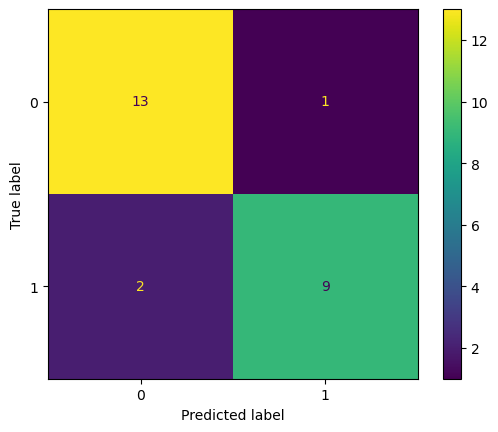

In [21]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [22]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.88
Precision: 0.9
Recall: 0.8181818181818182


# Experiment 3

In [23]:
pca = PCA(n_components=75)

In [24]:
train_data = pca.fit_transform(X_train)
test_data = pca.transform(X_test)

In [25]:
rfr = RandomForestClassifier(n_estimators = 100, n_jobs = 1, 
                                         random_state = 2024, verbose = 1,
                                         class_weight='balanced',oob_score=True)

In [26]:
rfr.fit(train_data, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


RandomForestClassifier(class_weight='balanced', n_jobs=1, oob_score=True,
                       random_state=2024, verbose=1)

In [27]:
y_pred = rfr.predict(test_data)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [28]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.96
Precision: 0.9166666666666666
Recall: 1.0


# Experiment 4

In [29]:
pca = PCA(n_components=50)
train_data = pca.fit_transform(X_train)
test_data = pca.transform(X_test)
rfr = RandomForestClassifier(n_estimators = 100, n_jobs = 1, 
                                         random_state = 2024, verbose = 1,
                                         class_weight='balanced',oob_score=True)
rfr.fit(train_data, y_train)
y_pred = rfr.predict(test_data)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [30]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.92
Precision: 0.8461538461538461
Recall: 1.0


# Experiment 5

In [31]:
pca = PCA(n_components=50)
train_data = pca.fit_transform(X_train)
test_data = pca.transform(X_test)
rfr = RandomForestClassifier(n_estimators = 400, n_jobs = 1, 
                                         random_state = 2024, verbose = 1,
                                         class_weight='balanced',oob_score=True)
rfr.fit(train_data, y_train)
y_pred = rfr.predict(test_data)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [32]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.92
Precision: 0.8461538461538461
Recall: 1.0


# Experiment 6

In [33]:
pca = PCA(n_components=40)
train_data = pca.fit_transform(X_train)
test_data = pca.transform(X_test)
rfr = RandomForestClassifier(n_estimators = 400, n_jobs = 1, 
                                         random_state = 2024, verbose = 1,
                                         class_weight='balanced',oob_score=True)
rfr.fit(train_data, y_train)
y_pred = rfr.predict(test_data)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [34]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.96
Precision: 0.9166666666666666
Recall: 1.0


# Experiment 7

In [35]:
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=15)

In [36]:
rand_search.fit(train_data, y_train)

RandomizedSearchCV(cv=15,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    max_depth=20,
                                                    max_features=None,
                                                    n_estimators=500),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f93d0c88d00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f93d0b90cd0>})

In [37]:
best_rf = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 8, 'n_estimators': 445}


In [38]:
y_pred = best_rf.predict(test_data)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.92
Precision: 0.8461538461538461
Recall: 1.0


# Experiment next

In [39]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
base_estimator = RandomForestClassifier(max_depth=14, n_estimators=250)
n_estimators = 250  # Number of weak learners (trees) to train
learning_rate = 0.5  # Weight applied to each weak learner's contribution
adaboost_model = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=n_estimators, learning_rate=learning_rate)

In [40]:
pca = PCA(n_components=200)
train_data = pca.fit_transform(X_train)
test_data = pca.transform(X_test)

In [41]:
adaboost_model.fit(train_data, y_train)
y_pred = adaboost_model.predict(test_data)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

/Users/dan/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.8
Precision: 1.0
Recall: 0.5454545454545454


# Experiment nextnext

In [42]:
from xgboost import XGBClassifier
import xgboost as xgb

In [43]:
pca = PCA(n_components=40)
train_data = pca.fit_transform(X_train)
test_data = pca.transform(X_test)

In [44]:
xgb_model = XGBClassifier(booster='gbtree', n_estimators=200, learning_rate=0.1, max_depth=15, base_estimator=base_estimator)

In [45]:
xgb_model.fit(train_data, y_train)
y_pred = xgb_model.predict(test_data)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

/Users/dan/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [16:55:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "base_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.92
Precision: 0.9090909090909091
Recall: 0.9090909090909091


In [46]:
# next

In [47]:
pca = PCA(n_components=220, random_state=1234)
train_data = pca.fit_transform(X_train)
test_data = pca.transform(X_test)

In [48]:
xgb_model = XGBClassifier(booster='gbtree', n_estimators=200, learning_rate=0.1, max_depth=15, base_estimator=base_estimator)
xgb_model.fit(train_data, y_train)
y_pred = xgb_model.predict(test_data)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

/Users/dan/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [16:55:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "base_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.92
Precision: 0.8461538461538461
Recall: 1.0


In [49]:
xgb_model = XGBClassifier(booster='gbtree', n_estimators=200, learning_rate=0.1, max_depth=15)
xgb_model.fit(train_data, y_train)
y_pred = xgb_model.predict(test_data)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.92
Precision: 0.8461538461538461
Recall: 1.0


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

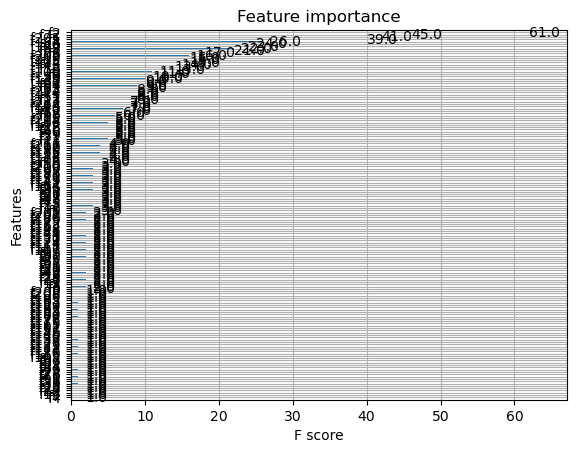

In [50]:
xgb.plot_importance(xgb_model)

In [51]:
important_mutations = xgb_model.get_booster().get_score(importance_type="gain")
keys = list(important_mutations.keys())
values = list(important_mutations.values())
kk = pd.DataFrame(data=values,index=keys,columns=["score"])
kk.nlargest(10, columns="score")

,score
f1,8.877346
f2,7.283005
f110,6.163505
f121,4.324733
f149,3.821274
f120,3.492501
f45,3.286800
f97,3.208244
f75,2.927866
f67,2.789061


In [52]:
len(important_mutations)

159

In [53]:
pca.components_[0]

array([ 0.01622159,  0.00650434,  0.00111105, ..., -0.00080318,
       -0.00256676,  0.        ])

In [54]:
oo = pd.DataFrame(pca.components_, columns = df.columns[1:])
oo.abs().sum(axis=0).sort_values(ascending=False).head(20)

BCOR_GRCh37_X:39921444-39921444_Missense-Mutation_SNP_T-T-C                  9.034101
PTEN_GRCh37_10:89717672-89717672_Nonsense-Mutation_SNP_C-C-T                 8.835132
FGFR2_GRCh37_10:123258034-123258034_Missense-Mutation_SNP_A-A-T_A-A-C        8.222079
KRAS_GRCh37_12:25398284-25398284_Missense-Mutation_SNP_C-C-A_C-C-T_C-C-G     8.161898
PIK3CA_GRCh37_3:178936091-178936091_Missense-Mutation_SNP_G-G-A_G-G-C        7.839846
PIK3CA_GRCh37_3:178936095-178936095_Missense-Mutation_SNP_A-A-C_A-A-G        7.838511
FGFR2_GRCh37_10:123279677-123279677_Missense-Mutation_SNP_G-G-C              7.834030
ING1_GRCh37_13:111372025-111372025_Nonsense-Mutation_SNP_C-C-T               7.820204
KRAS_GRCh37_12:25398285-25398285_Missense-Mutation_SNP_C-C-A_C-C-T           7.753226
PIK3CA_GRCh37_3:178921553-178921553_Missense-Mutation_SNP_T-T-A              7.674221
SMTNL2_GRCh37_17:4496467-4496467_Splice-Site_SNP_G-G-T                       7.566799
PPP2R1A_GRCh37_19:52716326-52716326_Missense-Mutation_

In [55]:
oo.abs().sum(axis=0).sort_values(ascending=False).head(20)

BCOR_GRCh37_X:39921444-39921444_Missense-Mutation_SNP_T-T-C                  9.034101
PTEN_GRCh37_10:89717672-89717672_Nonsense-Mutation_SNP_C-C-T                 8.835132
FGFR2_GRCh37_10:123258034-123258034_Missense-Mutation_SNP_A-A-T_A-A-C        8.222079
KRAS_GRCh37_12:25398284-25398284_Missense-Mutation_SNP_C-C-A_C-C-T_C-C-G     8.161898
PIK3CA_GRCh37_3:178936091-178936091_Missense-Mutation_SNP_G-G-A_G-G-C        7.839846
PIK3CA_GRCh37_3:178936095-178936095_Missense-Mutation_SNP_A-A-C_A-A-G        7.838511
FGFR2_GRCh37_10:123279677-123279677_Missense-Mutation_SNP_G-G-C              7.834030
ING1_GRCh37_13:111372025-111372025_Nonsense-Mutation_SNP_C-C-T               7.820204
KRAS_GRCh37_12:25398285-25398285_Missense-Mutation_SNP_C-C-A_C-C-T           7.753226
PIK3CA_GRCh37_3:178921553-178921553_Missense-Mutation_SNP_T-T-A              7.674221
SMTNL2_GRCh37_17:4496467-4496467_Splice-Site_SNP_G-G-T                       7.566799
PPP2R1A_GRCh37_19:52716326-52716326_Missense-Mutation_

In [56]:
xgb_model = XGBClassifier(booster='gbtree', n_estimators=200, learning_rate=0.1, max_depth=15)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.88
Precision: 0.8333333333333334
Recall: 0.9090909090909091


In [57]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [58]:
k = SelectKBest(f_classif, k=200)
X_new = k.fit_transform(X_train, y_train)

/Users/dan/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 157  357  363 ... 8071 8072 8084] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/dan/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [59]:
X_new.shape

(225, 200)

In [60]:
X_test_n = k.transform(X_test)

In [61]:
X_test_n.shape

(25, 200)

In [62]:
np.array(range(X_train.shape[1]))[k.get_support()]

array([  43,  159,  311,  391,  667,  748, 1002, 1009, 1013, 1018, 1024,
       1031, 1041, 1052, 1053, 1054, 1059, 1060, 1067, 1068, 1075, 1077,
       1081, 1084, 1094, 1104, 1107, 1113, 1117, 1118, 1120, 1122, 1126,
       1127, 1130, 1178, 1183, 1184, 1195, 1197, 1221, 1242, 1250, 1254,
       1262, 1266, 1269, 1278, 1289, 1294, 1307, 1316, 1321, 1334, 1339,
       1361, 1362, 1365, 1366, 1373, 1383, 1387, 1388, 1389, 1398, 1399,
       1402, 1407, 1411, 1418, 1426, 1427, 1431, 1451, 1453, 1457, 1460,
       1464, 1475, 1476, 1478, 1482, 1489, 1502, 1521, 1525, 1528, 1534,
       1535, 1539, 1555, 1556, 1560, 1561, 1564, 1575, 1589, 1617, 1628,
       1652, 1653, 1671, 1679, 1716, 1726, 1735, 1753, 1775, 1786, 1917,
       2214, 2430, 2431, 2435, 2438, 2450, 2474, 2479, 2487, 2495, 2514,
       2520, 2524, 2544, 2550, 2551, 2575, 2578, 2598, 2607, 2608, 3376,
       3382, 3385, 3386, 3388, 3399, 3400, 3402, 3404, 3408, 3412, 3421,
       3427, 3454, 3533, 3554, 3570, 3581, 3596, 36

In [63]:
np.array(range(X_train.shape[1]))[~k.get_support()]

array([   0,    1,    2, ..., 8082, 8083, 8084])

In [64]:
xgb_model = XGBClassifier(booster='gbtree', n_estimators=200, learning_rate=0.1, max_depth=15)
xgb_model.fit(X_new, y_train)
y_pred = xgb_model.predict(X_test_n)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.92
Precision: 0.8461538461538461
Recall: 1.0


In [65]:
tree_selector = SelectFromModel(DecisionTreeClassifier(), max_features=200)
X_train_tree = tree_selector.fit_transform(X_train, y_train)
X_test_tree = tree_selector.transform(X_test)

In [66]:
xgb_model = XGBClassifier(booster='gbtree', n_estimators=200, learning_rate=0.1, max_depth=15)
xgb_model.fit(X_train_tree, y_train)
y_pred = xgb_model.predict(X_test_tree)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.84
Precision: 0.8181818181818182
Recall: 0.8181818181818182


In [67]:
logreg_selector = SelectFromModel(LogisticRegression(), threshold=-np.inf, max_features=1000)
X_train_logreg = logreg_selector.fit_transform(X_train, y_train)
X_test_logreg = logreg_selector.transform(X_test)

In [68]:
xgb_model = XGBClassifier(booster='gbtree', n_estimators=200, learning_rate=0.1, max_depth=15)
xgb_model.fit(X_train_logreg, y_train)
y_pred = xgb_model.predict(X_test_logreg)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.88
Precision: 0.8333333333333334
Recall: 0.9090909090909091


In [69]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Creating a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SelectKBest with ANOVA F-value for feature selection
k_best_selector = SelectKBest(f_classif, k=10)
X_train_k_best = k_best_selector.fit_transform(X_train, y_train)
selected_features_k_best = np.array(range(X_train.shape[1]))[k_best_selector.get_support()]
removed_features_k_best = np.array(range(X_train.shape[1]))[~k_best_selector.get_support()]

# Apply SelectPercentile with ANOVA F-value for feature selection
percentile_selector = SelectPercentile(f_classif, percentile=50)
X_train_percentile = percentile_selector.fit_transform(X_train, y_train)
selected_features_percentile = np.array(range(X_train.shape[1]))[percentile_selector.get_support()]
removed_features_percentile = np.array(range(X_train.shape[1]))[~percentile_selector.get_support()]

# Apply SelectFromModel with Decision Tree for feature selection
tree_selector = SelectFromModel(DecisionTreeClassifier(), threshold=-np.inf, max_features=10)
X_train_tree = tree_selector.fit_transform(X_train, y_train)
selected_features_tree = np.array(range(X_train.shape[1]))[tree_selector.get_support()]
removed_features_tree = np.array(range(X_train.shape[1]))[~tree_selector.get_support()]

# Apply SelectFromModel with Logistic Regression for feature selection
logreg_selector = SelectFromModel(LogisticRegression(), threshold=-np.inf, max_features=10)
X_train_logreg = logreg_selector.fit_transform(X_train, y_train)
selected_features_logreg = np.array(range(X_train.shape[1]))[logreg_selector.get_support()]
removed_features_logreg = np.array(range(X_train.shape[1]))[~logreg_selector.get_support()]

# Display the selected and removed features for each method
print("Selected Features - SelectKBest:", selected_features_k_best)
print("Removed Features - SelectKBest:", removed_features_k_best)

print("\nSelected Features - SelectPercentile:", selected_features_percentile)
print("Removed Features - SelectPercentile:", removed_features_percentile)

print("\nSelected Features - SelectFromModel (Decision Tree):", selected_features_tree)
print("Removed Features - SelectFromModel (Decision Tree):", removed_features_tree)

print("\nSelected Features - SelectFromModel (Logistic Regression):", selected_features_logreg)
print("Removed Features - SelectFromModel (Logistic Regression):", removed_features_logreg)


Selected Features - SelectKBest: [ 0  1  2  5  6 10 11 14 18 19]
Removed Features - SelectKBest: [ 3  4  7  8  9 12 13 15 16 17]

Selected Features - SelectPercentile: [ 0  1  2  5  6 10 11 14 18 19]
Removed Features - SelectPercentile: [ 3  4  7  8  9 12 13 15 16 17]

Selected Features - SelectFromModel (Decision Tree): [ 1  2  3  5 14 15 16 17 18 19]
Removed Features - SelectFromModel (Decision Tree): [ 0  4  6  7  8  9 10 11 12 13]

Selected Features - SelectFromModel (Logistic Regression): [ 1  2  5 10 11 13 14 17 18 19]
Removed Features - SelectFromModel (Logistic Regression): [ 0  3  4  6  7  8  9 12 15 16]


In [70]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Creating a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=100, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality from 100 to 20
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_scaled)

# Get the importance of each original feature for each principal component
feature_importance = np.abs(pca.components_)

# Create a DataFrame to display the results
feature_names = [f"Feature_{i+1}" for i in range(X.shape[1])]
pc_names = [f"PC_{i+1}" for i in range(X_pca.shape[1])]

feature_importance_df = pd.DataFrame(feature_importance, columns=feature_names, index=pc_names)

# Display the DataFrame
print("Feature Importance for Each Principal Component:")
print(feature_importance_df)


Feature Importance for Each Principal Component:
       Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
PC_1    0.017132   0.037901   0.017100   0.039660   0.046382   0.003075   
PC_2    0.099840   0.120172   0.122124   0.097535   0.215229   0.026659   
PC_3    0.120504   0.119415   0.077242   0.034447   0.156342   0.137269   
PC_4    0.087596   0.178569   0.007831   0.107584   0.014077   0.112213   
PC_5    0.066030   0.002449   0.184905   0.112449   0.015321   0.017909   
PC_6    0.021038   0.102642   0.012776   0.052173   0.149696   0.176966   
PC_7    0.095816   0.002252   0.149758   0.294483   0.066713   0.004157   
PC_8    0.097151   0.073664   0.041408   0.096848   0.037477   0.038729   
PC_9    0.060864   0.003322   0.088141   0.005721   0.035367   0.103183   
PC_10   0.038207   0.140618   0.135339   0.025747   0.077494   0.016223   
PC_11   0.167956   0.030814   0.020491   0.045651   0.158651   0.149005   
PC_12   0.146921   0.181823   0.119471   0.071742  

In [71]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Creating a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=100, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality from 100 to 20
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_scaled)

# Get the importance of each original feature for each principal component
feature_importance = np.abs(pca.components_)

# Identify the top 5 features for each principal component
top_features = []
for i in range(X_pca.shape[1]):
    component_importance = feature_importance[i, :]
    top_feature_indices = np.argsort(component_importance)[-5:][::-1]
    top_features.append(top_feature_indices)

# Create a DataFrame to display the top features
feature_names = [f"Feature_{i+1}" for i in range(X.shape[1])]
pc_names = [f"PC_{i+1}" for i in range(X_pca.shape[1])]

top_features_df = pd.DataFrame(np.array(feature_names)[top_features], columns=[f"Top_Feature_{i+1}" for i in range(5)], index=pc_names)

# Display the DataFrame
print("Top 5 Features for Each Principal Component:")
print(top_features_df)


Top 5 Features for Each Principal Component:
      Top_Feature_1 Top_Feature_2 Top_Feature_3 Top_Feature_4 Top_Feature_5
PC_1     Feature_11    Feature_17    Feature_61    Feature_67    Feature_98
PC_2     Feature_56    Feature_87    Feature_15     Feature_5    Feature_36
PC_3     Feature_84    Feature_60    Feature_63    Feature_85    Feature_92
PC_4     Feature_71    Feature_97    Feature_26    Feature_93    Feature_52
PC_5     Feature_96    Feature_27    Feature_20    Feature_15    Feature_57
PC_6     Feature_35    Feature_72    Feature_58    Feature_79    Feature_30
PC_7     Feature_44    Feature_42    Feature_65    Feature_89    Feature_68
PC_8     Feature_38    Feature_64    Feature_13    Feature_21    Feature_76
PC_9     Feature_66    Feature_86    Feature_19    Feature_62    Feature_54
PC_10    Feature_72    Feature_43    Feature_62    Feature_40    Feature_90
PC_11    Feature_81    Feature_63    Feature_95    Feature_49    Feature_65
PC_12    Feature_64    Feature_79    Featur

In [72]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Creating a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=100, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality from 100 to 20
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_scaled)

# Get the importance of each original feature for each principal component
feature_importance = np.abs(pca.components_)

# Calculate the sum of importance for each feature across all principal components
sum_importance = np.sum(feature_importance, axis=0)

# Identify the indices of the top 5 features based on their sum of importance
top_feature_indices = np.argsort(sum_importance)[-5:][::-1]

# Map feature indices to feature names
feature_names = [f"Feature_{i+1}" for i in range(X.shape[1])]
common_top_feature_names = [feature_names[i] for i in top_feature_indices]

# Display the common top 5 features
print("Common Top 5 Features Across All Principal Components:")
print(common_top_feature_names)


Common Top 5 Features Across All Principal Components:
['Feature_2', 'Feature_55', 'Feature_38', 'Feature_54', 'Feature_3']


In [73]:
!pip install graphviz

<Figure size 20000x12000 with 0 Axes>

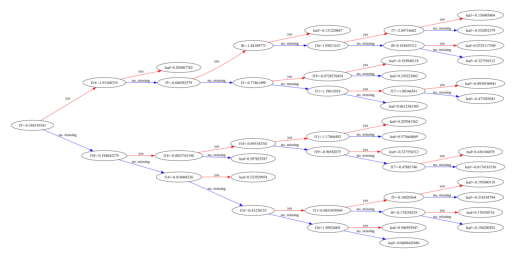

In [74]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming you have a trained XGBoost model stored in 'xgb_model'
# If you don't have XGBoost installed, you can install it using: pip install xgboost

# Create a simple synthetic dataset for demonstration purposes
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Plot the first tree in the XGBoost model (you can change the index)
plt.figure(figsize=(25, 15),dpi=800)
xgb.plot_tree(model, num_trees=0, rankdir='LR')
plt.savefig("wow.png",dpi=500)
plt.show()


In [75]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Creating a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=5)  # Assuming you want to reduce to 5 components
X_pca = pca.fit_transform(X_scaled)

# Get the feature weights (loadings) for each principal component
feature_weights = pca.components_

# Create a DataFrame to display the results
feature_names = [f"Feature_{i+1}" for i in range(X.shape[1])]
pc_names = [f"PC_{i+1}" for i in range(X_pca.shape[1])]

feature_weights_df = pd.DataFrame(feature_weights, columns=feature_names, index=pc_names)

# Display the DataFrame
print("Feature Weights for Each Principal Component:")
print(feature_weights_df)

Feature Weights for Each Principal Component:
      Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
PC_1  -0.002415  -0.565127  -0.021757  -0.023095   0.036523   0.497176   
PC_2   0.313245   0.046532  -0.124861  -0.318295  -0.275401   0.184232   
PC_3  -0.261660  -0.027325  -0.242409   0.013289  -0.049372  -0.054605   
PC_4   0.066617   0.027549   0.464562  -0.040669   0.126441   0.050870   
PC_5  -0.156493   0.028657   0.059801  -0.216808   0.264357   0.086866   

      Feature_7  Feature_8  Feature_9  Feature_10  Feature_11  Feature_12  \
PC_1   0.014997  -0.016899   0.001964    0.016932    0.030146   -0.027131   
PC_2   0.115880  -0.084491   0.153291   -0.429793   -0.267221   -0.075331   
PC_3   0.209314   0.400444   0.116309   -0.066408   -0.401449   -0.114814   
PC_4   0.004935  -0.169102   0.320599   -0.400747    0.218821    0.175144   
PC_5  -0.473010   0.225253   0.106320    0.058794   -0.267816    0.238645   

      Feature_13  Feature_14  Feature_15  Feat

In [76]:
top_n_features = 3

top_features_df = pd.DataFrame(index=pc_names, columns=range(top_n_features))

for i in range(X_pca.shape[1]):
    top_feature_indices = np.argsort(np.abs(feature_weights[i, :]))[-top_n_features:][::-1]
    top_features_df.loc[f"PC_{i+1}"] = top_feature_indices + 1  # Adding 1 to convert to 1-indexing

# Display the DataFrame with top features
print(f"Top {top_n_features} Features for Each Principal Component:")
print(top_features_df)


Top 3 Features for Each Principal Component:
       0   1   2
PC_1   2  19   6
PC_2  10  18   4
PC_3  16  11   8
PC_4   3  10  13
PC_5   7  14  20
